In [101]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [459]:
'''input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   transform = transforms.ToTensor()),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/Users/Amartya/data', train=False, download=True, 
                   transform = transforms.ToTensor()),
    batch_size=2000, shuffle=True)'''

"input_size  = 28*28   # images are 28x28 pixels\noutput_size = 10      # there are 10 classes\n\ntrain_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('/Users/Amartya/data', train=True, download=True,\n                   transform = transforms.ToTensor()),\n    batch_size=64, shuffle=True)\n\ntest_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('/Users/Amartya/data', train=False, download=True, \n                   transform = transforms.ToTensor()),\n    batch_size=2000, shuffle=True)"

In [102]:
trainset_01 = datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   transform = transforms.ToTensor())
idx = trainset_01.targets <= 10
trainset_01.targets = trainset_01.targets[idx]
trainset_01.data = trainset_01.data[idx]
train_loader01 = torch.utils.data.DataLoader(trainset_01,
    batch_size=64, shuffle=True)

In [103]:
testset_01 = datasets.MNIST('/Users/Amartya/data', train=False, download=True,
                   transform = transforms.ToTensor())
idx = testset_01.targets <= 10
testset_01.targets = testset_01.targets[idx]
testset_01.data = testset_01.data[idx]
test_loader01 = torch.utils.data.DataLoader(testset_01,
    batch_size=2000, shuffle=True)

In [104]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")


GPU not available, CPU used


In [105]:
dataiter = iter(train_loader01)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [106]:
images[0].numpy().shape

(1, 28, 28)

In [107]:
labels[0].item()

3

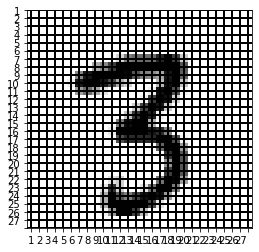

In [134]:
plt.imshow(images[62].numpy().squeeze(), cmap='gray_r');
ax = plt.gca();
ax.set_xticks(np.arange(0, 28, 1));
ax.set_yticks(np.arange(0, 28, 1));
ax.set_xticklabels(np.arange(1, 28, 1));
ax.set_yticklabels(np.arange(1, 28, 1));
ax.grid(color='black', linestyle='-', linewidth=2)

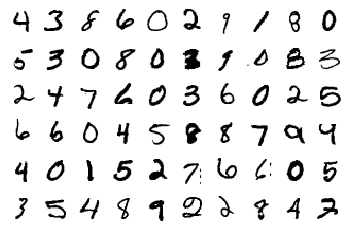

In [109]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [42]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        #First FC layer - Win
        self.fc1 = nn.Linear(input_size, hidden_dim)
        # RNN Layer Wrec
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)   
        # ReLU Layer
        self.relu = nn.ReLU()
        # Fully connected layer - Wout
        self.fc2 = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
    
        x = self.fc1(x)
        
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x)
        #print('after rec layer', out.size())
        
        #taking just the last time step
        out = out[:, -1, :]
        
        #Hidden Activation Layer
        out = self.relu(out)
        #print('after relu layer', out.size())
        
        out = self.fc2(out)
        #print('after fc2', out.size())
        return out
    

    

In [43]:
# Hyper Parameters
EPOCH = 5               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 784          # rnn time step / image height
INPUT_SIZE = 1         # rnn input size / image width
LR = 0.01               # learning rate

In [44]:
model = Model(28, 10, 64, 1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [63]:
#test set
test_x, test_y = iter(test_loader01).next()
print(test_x.size())
test_x01 = test_x.view(-1,28,28)
print(test_x.size())
test_y01 = test_y.numpy().squeeze()

torch.Size([2000, 1, 28, 28])
torch.Size([2000, 1, 28, 28])


In [1184]:
final_accuracy = 0
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader01):
        model.train()
        x = x.to(device)
        y = y.to(device)# gives batch data
        x = x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)
                                       # batch y

        output = model(x)                               # rnn output
        loss = loss_func(output, y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
        if step % 50 == 0:
            model.eval()
            test_x01.to(device)
            with torch.no_grad():
                test_output = model(test_x01)                   # (samples, time_step, input_size)
                pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y01) / float(test_y01.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)
            final_accuracy = accuracy
            if final_accuracy > 0.999:
                break
    if final_accuracy > 0.999:
        #torch.save(model.state_dict(), '/Users/Amartya/01.pth')
        print('model saved')
        break
        
    
                

Epoch:  0 | train loss: 2.2456 | test accuracy: 0.46
Epoch:  0 | train loss: 0.5156 | test accuracy: 0.98
Epoch:  0 | train loss: 0.1940 | test accuracy: 0.88
Epoch:  0 | train loss: 0.1298 | test accuracy: 0.98
Epoch:  1 | train loss: 0.0473 | test accuracy: 0.98
Epoch:  1 | train loss: 0.0137 | test accuracy: 1.00
Epoch:  1 | train loss: 0.0129 | test accuracy: 1.00
Epoch:  1 | train loss: 0.0106 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0075 | test accuracy: 1.00
Epoch:  2 | train loss: 0.0039 | test accuracy: 1.00
Epoch:  2 | train loss: 0.0086 | test accuracy: 1.00
Epoch:  2 | train loss: 0.0056 | test accuracy: 1.00
model saved


In [1185]:
model.load_state_dict(torch.load('/Users/Amartya/01.pth'))
model.eval()
correct_count, all_count = 0, 0
for images,labels in test_loader01:
  for i in range(len(labels)):
    img = images[i].view(-1, 28,28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 2115

Model Accuracy = 0.9995271867612293


In [45]:
#GAN
#RNN-Generator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, n_layers=1):
        super(Generator, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        #First FC layer - Win
        self.fc1 = nn.Linear(input_size, hidden_dim)
        # RNN Layer Wrec
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)   
        # ReLU Layer
        self.relu = nn.ReLU()
        # Fully connected layer - Wout
        self.fc2 = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
    
        x = self.fc1(x)
        
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x)
        
        #Hidden Activation Layer
        out = self.relu(out)
        
        out = self.fc2(out)
        
        
        return out

            
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 28, 4, 2, 1),
            nn.AvgPool2d(6,2,1), nn.BatchNorm2d(28),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(28, 1, 6, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, input):
        input = input.view(-1,1,28,28)
        return self.main(input)
    
#Discriminator1 and Generator1 for testing pipeline
class Generator1(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator1, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out
class Discriminator1(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator1, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

class Discriminator2(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Discriminator2, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        #First FC layer - Win
        self.fc1 = nn.Linear(input_size, hidden_dim)
        # RNN Layer Wrec
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)   
        # ReLU Layer
        self.relu = nn.ReLU()
        # Fully connected layer - Wout
        self.fc2 = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
    
        x = x.view(-1,28,28)
        
        x = self.fc1(x)
        
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x)
        #print('after rec layer', out.size())
        
        #taking just the last time step
        out = out[:, -1, :]
        
        #Hidden Activation Layer
        out = self.relu(out)
        #print('after relu layer', out.size())
        
        out = self.fc2(out)
        #print('after fc2', out.size())
        return out
        


In [46]:
def new_size(inputsize, kernel, stride, padding):
    return (inputsize + 2*padding - (kernel - 1) - 1)/stride + 1

In [47]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [15]:
# instantiate discriminator and generator
D = Discriminator1(input_size, d_hidden_size, d_output_size)
#D = Discriminator()
G = Generator1(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print(G)
#D.to(device)
#G.to(device)

Discriminator1(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator1(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [48]:
# discriminator loss
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [49]:
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [1244]:
#Training the GAN

# training hyperparams
num_epochs = 15

# keep track of loss and generated, "fake" samples
#samples = []
#losses = []

print_every = 50

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader01):
                
        real_images = real_images.to(device)
        
        batch_size = real_images.size(0)
        
        #real_images = real_images.view(-1, 28, 28)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = torch.empty([64, z_size]).uniform_(-1,1)
        #z = torch.empty([64, 28, z_size]).uniform_(-1,1)
        fake_images = G(z)
        fake_images = fake_images.to(device)
        #fake_images = fake_images.view(-1,28,28)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = torch.empty([64, z_size]).uniform_(-1,1)
        #z = torch.empty([64, 28, z_size]).uniform_(-1,1)
        fake_images = G(z)
        fake_images = fake_images.to(device)
        #fake_images = fake_images.view(-1,28,28)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

Epoch [    1/   15] | d_loss: 1.0913 | g_loss: 1.0340
Epoch [    1/   15] | d_loss: 1.0871 | g_loss: 1.6390
Epoch [    1/   15] | d_loss: 1.0812 | g_loss: 1.3904
Epoch [    1/   15] | d_loss: 0.9797 | g_loss: 2.0184
Epoch [    2/   15] | d_loss: 1.0403 | g_loss: 1.5598
Epoch [    2/   15] | d_loss: 0.8960 | g_loss: 2.0808
Epoch [    2/   15] | d_loss: 1.1384 | g_loss: 2.0979
Epoch [    2/   15] | d_loss: 1.2032 | g_loss: 1.0710
Epoch [    3/   15] | d_loss: 1.2401 | g_loss: 1.1973
Epoch [    3/   15] | d_loss: 1.2411 | g_loss: 1.4925
Epoch [    3/   15] | d_loss: 1.2115 | g_loss: 1.1314
Epoch [    3/   15] | d_loss: 1.2200 | g_loss: 0.9381
Epoch [    4/   15] | d_loss: 1.1878 | g_loss: 1.3532
Epoch [    4/   15] | d_loss: 1.1334 | g_loss: 1.4594
Epoch [    4/   15] | d_loss: 1.1990 | g_loss: 1.2920
Epoch [    4/   15] | d_loss: 1.1693 | g_loss: 1.1432
Epoch [    5/   15] | d_loss: 1.0203 | g_loss: 1.9734
Epoch [    5/   15] | d_loss: 1.2775 | g_loss: 1.0844
Epoch [    5/   15] | d_loss

In [1245]:
#Generating Samples and transforming them to feed into the model
z = torch.empty([12665, z_size]).uniform_(-1,1)
G.eval()
samples=G(z)
samples = (samples + 1)* 0.5


In [116]:
def view_samples(samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

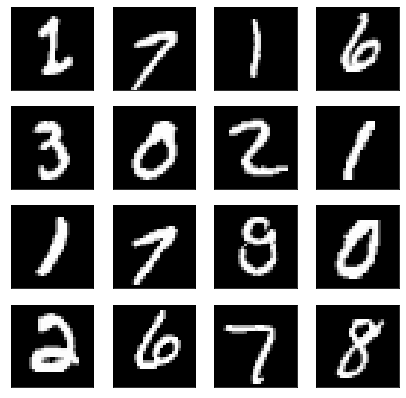

In [118]:
#checking generated samples
view_samples(trainset_01.data[70:90])

In [1247]:
#Getting targets for the generated model by running the trained model on the samples
model.load_state_dict(torch.load('/Users/Amartya/01.pth'))
model.eval()
samples = samples.view(-1,28,28)
with torch.no_grad():
    k=model(samples)
class_labels = torch.argmax(F.softmax(k, dim = 1), dim = 1)

In [1248]:
class_labels[70:90]

tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1])

In [1250]:
#saving the generated samples and targets - no test set
torch.save((samples, class_labels), 'file1.pt')

In [78]:
#Dataset class for Generated Samples
class GeneratedDataset(Dataset):

    def __init__(self, data_file, transform=None):
        
        self.datafile = data_file
        self.data, self.targets = torch.load(self.datafile)
        self.data = self.data.view(-1,1,28,28)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        img, target = self.data[index], int(self.targets[index])

        if self.transform:
            img = self.transform(img)

        return img, target

In [79]:
generated01_trainset = GeneratedDataset('file1.pt')
generated01_trainloader = torch.utils.data.DataLoader(generated01_trainset,
    batch_size=64, shuffle=True)

In [20]:
#preparing the dataset for learning 2 and 3
trainset_23 = datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   transform = transforms.ToTensor())
idx = torch.as_tensor(np.logical_or(trainset_23.train_labels == 2, trainset_23.train_labels == 3), dtype = torch.bool)

trainset_23.targets = trainset_23.targets[idx]
#trainset_23.targets -= 2
trainset_23.data = trainset_23.data[idx]
train_loader23 = torch.utils.data.DataLoader(trainset_23,
    batch_size=64, shuffle=True)
testset_23 = datasets.MNIST('/Users/Amartya/data', train=False, download=True,
                   transform = transforms.ToTensor())
idx = torch.as_tensor(np.logical_or(testset_23.train_labels == 2, testset_23.train_labels == 3), dtype = torch.bool)
testset_23.targets = testset_23.targets[idx]
#testset_23.targets -= 2
testset_23.data = testset_23.data[idx]
test_loader23 = torch.utils.data.DataLoader(testset_23,
    batch_size=2000, shuffle=True)
test_x, test_y = iter(test_loader23).next()
print(test_x.size())
test_x23 = test_x.view(-1,28,28)
print(test_x.size())
test_y23 = test_y.numpy().squeeze()
testset_0123 = datasets.MNIST('/Users/Amartya/data', train=False, download=True,
                   transform = transforms.ToTensor())
idx = torch.as_tensor(testset_0123.train_labels <= 3, dtype = torch.bool)
testset_0123.targets = testset_0123.targets[idx]
testset_0123.data = testset_0123.data[idx]
test_loader0123 = torch.utils.data.DataLoader(testset_0123,
    batch_size=2000, shuffle=True)
test_x, test_y = iter(test_loader0123).next()
test_x0123 = test_x.view(-1,28,28)
test_y0123 = test_y.numpy().squeeze()

/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([2000, 1, 28, 28])
torch.Size([2000, 1, 28, 28])


In [159]:
generated01_trainset.data.dtype

torch.float32

In [163]:
trainset_23.data = trainset_23.data.float()

trainset_23.data.dtype

torch.float32

In [164]:
total_data = torch.cat((trainset_23.data, generated01_trainset.data.view(-1,28,28)))

In [1324]:
#Training 2 and 3 along with 0 and 1
model.load_state_dict(torch.load('/Users/Amartya/01.pth'))
EPOCH = 8
for epoch in range(EPOCH):
    data = iter(generated01_trainloader)
    for step, (x, y) in enumerate(train_loader23): 
        model.train()
        x = x.to(device)
        y = y.to(device)# gives batch data
        x = x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)
        output = model(x)                               # rnn output
        new_loss = loss_func(output, y)                   # cross entropy loss
        x_, y_ = data.next()
        x_ = x_.to(device)
        y_ = y_.to(device)
        x_ = x_.view(-1, 28, 28)
        output1 = model(x_)
        old_loss = loss_func(output1, y_)
        loss = 0.5 * old_loss + 0.5 * new_loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
        if step % 50 == 0:
            model.eval()
            test_x23.to(device)
            test_x01.to(device)
            with torch.no_grad():
                test_output = model(test_x23)                   # (samples, time_step, input_size)
                pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
                pred_y01 = torch.max(model(test_x01), 1)[1].data.numpy().squeeze()
                pred_y0123 = torch.max(model(test_x0123), 1)[1].data.numpy().squeeze()
            accuracy23 = sum(pred_y == test_y23) / float(test_y23.size)
            accuracy01 = sum(pred_y01 == test_y01) / float(test_y01.size)
            accuracy0123 = sum(pred_y0123 == test_y0123) / float(test_y0123.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test23 accuracy: %.2f' % accuracy23, '| test01 accuracy: %.2f' % accuracy01,'| test0123 accuracy: %.2f' % accuracy0123)
            #if accuracy23 >= 0.85 and accuracy01 > 0.80:
                #torch.save(model.state_dict(), '/Users/Amartya/23' +str(epoch) + str(step) + '.pth')
    
                

Epoch:  0 | train loss: 6.3604 | test23 accuracy: 0.00 | test01 accuracy: 1.00 | test0123 accuracy: 0.51
Epoch:  0 | train loss: 0.7750 | test23 accuracy: 0.52 | test01 accuracy: 0.54 | test0123 accuracy: 0.53
Epoch:  0 | train loss: 0.5009 | test23 accuracy: 0.71 | test01 accuracy: 0.65 | test0123 accuracy: 0.68
Epoch:  0 | train loss: 0.2882 | test23 accuracy: 0.85 | test01 accuracy: 0.65 | test0123 accuracy: 0.74
Epoch:  1 | train loss: 0.2844 | test23 accuracy: 0.90 | test01 accuracy: 0.73 | test0123 accuracy: 0.81
Epoch:  1 | train loss: 0.1137 | test23 accuracy: 0.92 | test01 accuracy: 0.67 | test0123 accuracy: 0.80
Epoch:  1 | train loss: 0.1573 | test23 accuracy: 0.92 | test01 accuracy: 0.64 | test0123 accuracy: 0.78
Epoch:  1 | train loss: 0.2791 | test23 accuracy: 0.93 | test01 accuracy: 0.61 | test0123 accuracy: 0.77
Epoch:  2 | train loss: 0.1148 | test23 accuracy: 0.93 | test01 accuracy: 0.54 | test0123 accuracy: 0.73
Epoch:  2 | train loss: 0.1385 | test23 accuracy: 0.95 

KeyboardInterrupt: 

In [1279]:
#torch.save(model.state_dict(), '/Users/Amartya/23' +'7150.pth')

In [65]:
model.load_state_dict(torch.load('Good models for 0123/234150.pth'))
model.eval()
correct_count, all_count = 0, 0
for images,labels in test_loader23:
  for i in range(len(labels)):
    img = images[i].view(-1, 28,28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 2042

Model Accuracy = 0.9363369245837414


In [94]:
#Extending to 3 tasks
#First train a new GAN, for which data will come from the older GAN and new true data
#Generating data from old GAN - 1st task
'''z = torch.empty([12665, z_size]).uniform_(-1,1)
G.eval()
samples=G(z)
samples = (samples + 1)* 0.5
model.eval()
samples = samples.view(-1,28,28)
with torch.no_grad():
    k=model(samples)
class_labels = torch.argmax(F.softmax(k, dim = 1), dim = 1)
torch.save((samples, class_labels), 'file01.pt')'''
#Loading it into a dataloader
generated01_trainset = GeneratedDataset('file01.pt')
old_trainloader = torch.utils.data.DataLoader(generated01_trainset,
    batch_size=32, shuffle=True)
train_loader23 = torch.utils.data.DataLoader(trainset_23,
    batch_size=32, shuffle=True)
trainset_0123 = datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   transform = transforms.ToTensor())
idx = trainset_0123.train_labels <= 3
trainset_0123.targets = trainset_0123.targets[idx]
#testset_23.targets -= 2
trainset_0123.data = trainset_0123.data[idx]
train_loader0123 = torch.utils.data.DataLoader(trainset_0123,
    batch_size=64, shuffle=True)


/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [53]:
generated01_trainset[0][0].size()

torch.Size([1, 28, 28])

In [54]:
#Creating the new GAN
D1 = Discriminator1(input_size, d_hidden_size, d_output_size)
#D = Discriminator()
G1 = Generator1(z_size, g_hidden_size, g_output_size)

d_optimizer = optim.Adam(D1.parameters(), lr)
g_optimizer = optim.Adam(G1.parameters(), lr)

# check that they are as you expect
print(D1)
print(G1)
D1.to(device)
G1.to(device)
#Training the new GAN
#Training the GAN

# training hyperparams
num_epochs = 60

# keep track of loss and generated, "fake" samples
#samples = []
#losses = []

print_every = 50

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D1.train()
G1.train()
for epoch in range(num_epochs):
    
    #data = iter(old_trainloader)
    
    for batch_i, (real_images, _) in enumerate(train_loader0123):
                
        real_images = real_images.to(device)
        
        batch_size = real_images.size(0)
        
        #real_images = real_images.view(-1, 28, 28)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        #x_, _ = data.next()
        
        #x_ = x_.to(device)
        
        #x_ = x_*2 - 1
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D1(real_images)
        d_real_loss = real_loss(D_real, smooth=True) #+ real_loss(D1(x_), smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = torch.empty([64, z_size]).uniform_(-1,1)
        #z = torch.empty([64, 28, z_size]).uniform_(-1,1)
        fake_images = G1(z)
        fake_images = fake_images.to(device)
        #fake_images = fake_images.view(-1,28,28)
        
        # Compute the discriminator losses on fake images        
        D_fake = D1(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = torch.empty([64, z_size]).uniform_(-1,1)
        #z = torch.empty([64, 28, z_size]).uniform_(-1,1)
        fake_images = G1(z)
        fake_images = fake_images.to(device)
        #fake_images = fake_images.view(-1,28,28)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D1(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

Discriminator1(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator1(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch [    1/   60] | d_loss: 1.3837 | g_loss: 0.7290
Epoch [    1/   60] | d_loss: 1.0144 | g_loss: 0.9813
Epoch [    1/   60] | d_loss: 1.1261 | g_loss: 1.3203
Epoch [    1/   60] | d_loss: 0.7208 | g_loss: 2.3172
Epoch [    1/   60] | d_loss: 0.5389 | g_loss: 6.8260
Epoch [    1/   60] | d_loss: 0.9637 | g_loss: 2.3668
Epoch [    1/   60] | d_loss: 1.0106 | g_loss: 7.2322
Epoch [    1/   60

In [55]:
#torch.save(G1.state_dict(), '/Users/Amartya/' + 'gen0123.pth')

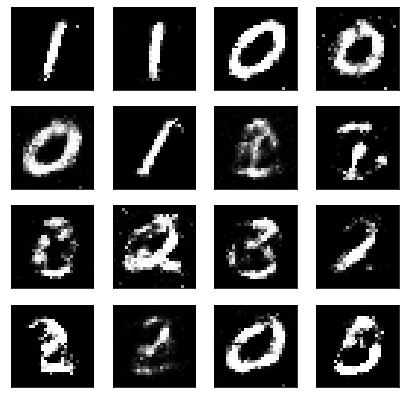

In [59]:
#preparing old dataset(0,1,2, 3) for learning 4 and 5
G1.load_state_dict(torch.load('/Users/Amartya/gen0123.pth'))
z = torch.empty([22000, z_size]).uniform_(-1,1)
G1.eval()
samples=G1(z)
samples = (samples + 1)* 0.5
#checking new GAN samples
#data = iter(train_loader23)
#x,y = data.next()
view_samples(samples[70:90])


In [35]:
#labels
'''model.load_state_dict(torch.load('Good models for 0123/234150.pth'))
model.eval()
samples = samples.view(-1,28,28)
with torch.no_grad():
    k=model(samples)
class_labels = torch.argmax(F.softmax(k, dim = 1), dim = 1)'''

In [60]:
#len(class_labels[class_labels==3])
torch.save(samples, 'new0123.pt')

In [37]:
#idx = class_labels ==1

In [38]:
#len(class_labels[idx])

6669

In [66]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(4, 2)

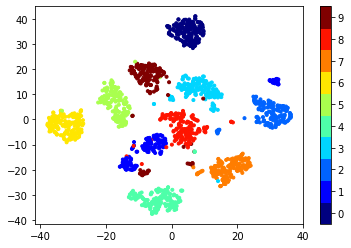

In [69]:
from sklearn.datasets import load_digits
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt

digits = load_digits()
embeddings = TSNE(n_jobs=4).fit_transform(digits.data)
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]
plt.scatter(vis_x, vis_y, c=digits.target, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [71]:
digits.data.shape

(1797, 64)

In [73]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [84]:
trainset_01.data.view(-1,784).numpy().shape

(12665, 784)

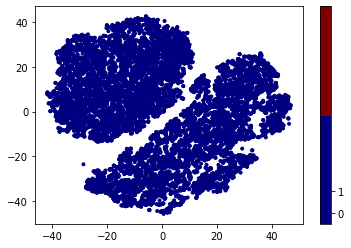

In [90]:

embeddings = TSNE(n_jobs=4).fit_transform(trainset_01.data.view(-1,784).numpy())
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]
plt.scatter(vis_x, vis_y, c=trainset_01.targets.view(12665).numpy(), cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [89]:
trainset_01.targets.view(12665).numpy().shape

(12665,)

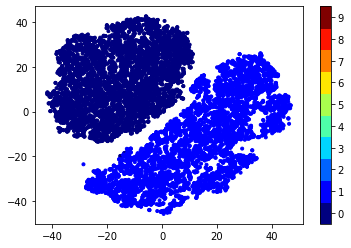

In [91]:
embeddings = TSNE(n_jobs=4).fit_transform(trainset_01.data.view(-1,784).numpy())
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]
plt.scatter(vis_x, vis_y, c=trainset_01.targets.view(12665).numpy(), cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

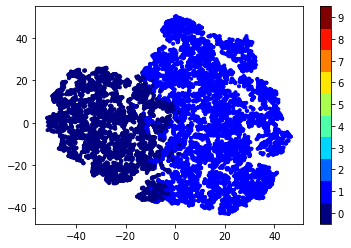

In [93]:
embeddings = TSNE(n_jobs=4).fit_transform(generated01_trainset.data.view(-1,784).detach().numpy())
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]
plt.scatter(vis_x, vis_y, c=generated01_trainset.targets.view(12665).detach().numpy(), cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

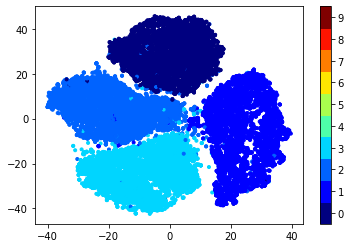

In [95]:
embeddings = TSNE(n_jobs=4).fit_transform(trainset_0123.data.view(-1,784).numpy())
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]
plt.scatter(vis_x, vis_y, c=trainset_0123.targets.view(-1).numpy(), cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [97]:
generated0123_trainset = GeneratedDataset('file0123.pt')

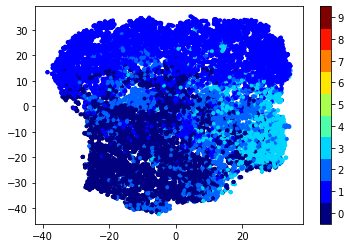

In [98]:
embeddings = TSNE(n_jobs=4).fit_transform(generated0123_trainset.data.view(-1,784).numpy())
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]
plt.scatter(vis_x, vis_y, c=generated0123_trainset.targets.view(-1).numpy(), cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

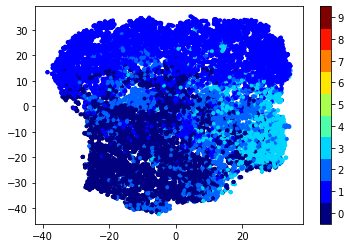

In [100]:
plt.scatter(vis_x, vis_y, c=generated0123_trainset.targets.view(-1).numpy(), cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [39]:
#torch.save((samples, class_labels), 'file0123_gan.pt')
#trainset_0123 = datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   #transform = transforms.ToTensor())
#idx = trainset_0123.train_labels <= 3
#trainset_0123.targets = trainset_0123.targets[idx]
#testset_23.targets -= 2
#trainset_0123.data = trainset_0123.data[idx]

generated0123_trainset = GeneratedDataset('file0123_gan.pt')
old_trainloader = torch.utils.data.DataLoader(generated0123_trainset, batch_size=64, shuffle=True)


In [32]:
trainset_45 = datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   transform = transforms.ToTensor())
idx = torch.as_tensor(np.logical_or(trainset_45.train_labels == 4, trainset_45.train_labels == 5), dtype = torch.bool)

trainset_45.targets = trainset_45.targets[idx]
#trainset_23.targets -= 2
trainset_45.data = trainset_45.data[idx]
train_loader45 = torch.utils.data.DataLoader(trainset_45,
    batch_size=64, shuffle=True)
testset_45 = datasets.MNIST('/Users/Amartya/data', train=False, download=True,
                   transform = transforms.ToTensor())
idx = torch.as_tensor(np.logical_or(testset_45.train_labels == 4, testset_45.train_labels == 5), dtype = torch.bool)
testset_45.targets = testset_45.targets[idx]
#testset_23.targets -= 2
testset_45.data = testset_45.data[idx]
test_loader45 = torch.utils.data.DataLoader(testset_45,
    batch_size=2000, shuffle=True)
test_x, test_y = iter(test_loader45).next()
print(test_x.size())
test_x45 = test_x.view(-1,28,28)
print(test_x.size())
test_y45 = test_y.numpy().squeeze()
testset_012345 = datasets.MNIST('/Users/Amartya/data', train=False, download=True,
                   transform = transforms.ToTensor())
idx = testset_012345.train_labels <= 5

testset_012345.data = testset_012345.data[idx]
testset_012345.targets = testset_012345.targets[idx]


test_loader012345 = torch.utils.data.DataLoader(testset_012345,
    batch_size=2000, shuffle=True)
test_x012345, test_y012345 = iter(test_loader012345).next()
test_x012345 = test_x012345.view(-1,28,28)
test_y012345 = test_y012345.numpy().squeeze()



torch.Size([1874, 1, 28, 28])
torch.Size([1874, 1, 28, 28])


In [33]:
len(trainset_45)

11263

In [22]:
#Learning 4 and 5 along with 0, 1, 2 and 3
model.load_state_dict(torch.load('Good models for 0123/234150.pth'))
EPOCH = 10
for epoch in range(EPOCH):
    data = iter(old_trainloader)
    for step, (x, y) in enumerate(train_loader45): 
        model.train()
        x = x.to(device)
        y = y.to(device)# gives batch data
        x = x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)
        output = model(x)                               # rnn output
        new_loss = loss_func(output, y)                   # cross entropy loss
        x_, y_ = data.next()
        x_ = x_.to(device)
        y_ = y_.to(device)
        x_ = x_.view(-1, 28, 28)
        output1 = model(x_)
        old_loss = loss_func(output1, y_)
        loss = 0.9*old_loss + 0.1*new_loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
        if step % 50 == 0:
            model.eval()
            test_x45.to(device)
            test_x0123.to(device)
            test_x012345.to(device)
            
            with torch.no_grad():                   
                pred_y45 = torch.max(model(test_x45), 1)[1].data.numpy().squeeze()
                pred_y0123 = torch.max(model(test_x0123), 1)[1].data.numpy().squeeze()
                pred_y012345 = torch.max(model(test_x012345), 1)[1].data.numpy().squeeze()
            
            accuracy45 = sum(pred_y45 == test_y45) / float(test_y45.size)
            accuracy0123 = sum(pred_y0123 == test_y0123) / float(test_y0123.size)
            accuracy012345 = sum(pred_y012345 == test_y012345) / float(test_y012345.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test45 accuracy: %.2f' % accuracy45, '| test0123 accuracy: %.2f' % accuracy0123,'| test012345 accuracy: %.2f' % accuracy012345)
            if accuracy0123 >= 0.80 and accuracy45 >= 0.80:
                torch.save(model.state_dict(), '/Users/Amartya/45' +str(epoch) + str(step) + '.pth')
    #print('model saved')
    #break

Epoch:  0 | train loss: 1.9692 | test45 accuracy: 0.00 | test0123 accuracy: 0.93 | test012345 accuracy: 0.62
Epoch:  0 | train loss: 0.6335 | test45 accuracy: 0.19 | test0123 accuracy: 0.90 | test012345 accuracy: 0.67
Epoch:  0 | train loss: 0.3819 | test45 accuracy: 0.41 | test0123 accuracy: 0.87 | test012345 accuracy: 0.71
Epoch:  0 | train loss: 0.5289 | test45 accuracy: 0.54 | test0123 accuracy: 0.86 | test012345 accuracy: 0.75
Epoch:  1 | train loss: 0.3184 | test45 accuracy: 0.70 | test0123 accuracy: 0.77 | test012345 accuracy: 0.73
Epoch:  1 | train loss: 0.3870 | test45 accuracy: 0.76 | test0123 accuracy: 0.78 | test012345 accuracy: 0.77
Epoch:  1 | train loss: 0.2691 | test45 accuracy: 0.90 | test0123 accuracy: 0.72 | test012345 accuracy: 0.77
Epoch:  1 | train loss: 0.3080 | test45 accuracy: 0.86 | test0123 accuracy: 0.73 | test012345 accuracy: 0.77
Epoch:  2 | train loss: 0.1971 | test45 accuracy: 0.87 | test0123 accuracy: 0.73 | test012345 accuracy: 0.77
Epoch:  2 | train l

In [23]:
model.load_state_dict(torch.load('452150.pth'))
model.eval()
correct_count, all_count = 0, 0
for images,labels in test_loader012345:
  for i in range(len(labels)):
    img = images[i].view(-1, 28,28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))


Number Of Images Tested = 6031

Model Accuracy = 0.8184380699718123


In [25]:
#Repeating the above for creating a new GAN for 0,1,2,3,4,5
#Extending to 4 tasks
#First train a new GAN, for which data will come from the older GAN and new true data
#Generating data from old GAN - 1st task
z = torch.empty([24000, z_size]).uniform_(-1,1)
#G1.eval()
#samples=G1(z)
samples = (samples + 1)* 0.5
model.eval()
samples = samples.view(-1,28,28)
with torch.no_grad():
    k=model(samples)
class_labels = torch.argmax(F.softmax(k, dim = 1), dim = 1)
torch.save((samples, class_labels), 'file0123_1.pt')
#Loading it into a dataloader
generated0123_trainset = GeneratedDataset('file0123_1.pt')

#old_trainloader = torch.utils.data.DataLoader(generated0123_trainset,
    #batch_size=42, shuffle=True)
#train_loader45 = torch.utils.data.DataLoader(trainset_45,
    #batch_size=22, shuffle=True)
trainset_012345 = datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   transform = transforms.ToTensor())
idx = trainset_012345.train_labels <= 5

trainset_012345.data = trainset_012345.data[idx]
trainset_012345.targets = trainset_012345.targets[idx]


train_loader012345 = torch.utils.data.DataLoader(trainset_012345,
    batch_size=64, shuffle=True)

In [27]:
#Creating the new GAN
D2 = Discriminator1(input_size, d_hidden_size, d_output_size)
G2 = Generator1(z_size, g_hidden_size, g_output_size)

d_optimizer = optim.Adam(D2.parameters(), lr)
g_optimizer = optim.Adam(G2.parameters(), lr)

# check that they are as you expect
print(D2)
print(G2)
D2.to(device)
G2.to(device)
#Training the new GAN
#Training the GAN

# training hyperparams
num_epochs = 60

# keep track of loss and generated, "fake" samples
#samples = []
#losses = []

print_every = 50

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D2.train()
G2.train()
for epoch in range(num_epochs):
    
    data = iter(old_trainloader)
    
    for batch_i, (real_images, _) in enumerate(train_loader012345):
                
        real_images = real_images.to(device)
        
        batch_size = real_images.size(0)
        
        #real_images = real_images.view(-1, 28, 28)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        #x_, _ = data.next()
        
        #x_ = x_.to(device)
        
        #x_ = x_*2 - 1
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D2(real_images)
        d_real_loss = real_loss(D_real, smooth=True) #+ real_loss(D1(x_), smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = torch.empty([64, z_size]).uniform_(-1,1)
        #z = torch.empty([64, 28, z_size]).uniform_(-1,1)
        fake_images = G2(z)
        fake_images = fake_images.to(device)
        #fake_images = fake_images.view(-1,28,28)
        
        # Compute the discriminator losses on fake images        
        D_fake = D2(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = torch.empty([64, z_size]).uniform_(-1,1)
        #z = torch.empty([64, 28, z_size]).uniform_(-1,1)
        fake_images = G2(z)
        fake_images = fake_images.to(device)
        #fake_images = fake_images.view(-1,28,28)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D2(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

Discriminator1(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator1(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch [    1/   60] | d_loss: 1.4216 | g_loss: 0.5994
Epoch [    1/   60] | d_loss: 1.0749 | g_loss: 0.7345
Epoch [    1/   60] | d_loss: 1.0440 | g_loss: 1.1381
Epoch [    1/   60] | d_loss: 1.0386 | g_loss: 1.2549
Epoch [    1/   60] | d_loss: 0.4488 | g_loss: 9.9921
Epoch [    1/   60] | d_loss: 1.7144 | g_loss: 1.1109
Epoch [    1/   60] | d_loss: 0.9459 | g_loss: 3.4703
Epoch [    1/   60

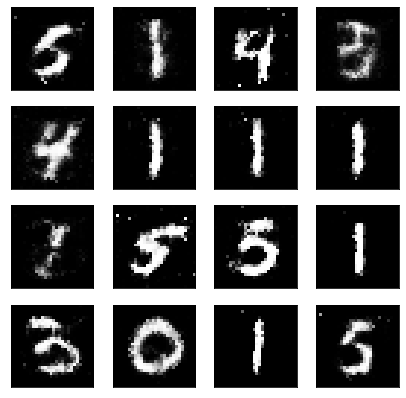

In [30]:
#preparing old dataset(0, 1, 2, 3, 4, 5) for learning 6 and 7
z = torch.empty([24000, z_size]).uniform_(-1,1)
G2.eval()
samples=G2(z)
samples = (samples + 1)* 0.5
#checking new GAN samples
view_samples(samples[70:90])

In [31]:
#labels
model.load_state_dict(torch.load('452150.pth'))
model.eval()
samples = samples.view(-1,28,28)
with torch.no_grad():
    k=model(samples)
class_labels = torch.argmax(F.softmax(k, dim = 1), dim = 1)
class_labels[70:90]

tensor([3, 1, 3, 1, 1, 1, 1, 1, 1, 2, 5, 1, 2, 0, 1, 3, 3, 4, 3, 0])

In [32]:
torch.save((samples, class_labels), 'file012345.pt')
generated012345_trainset = GeneratedDataset('file012345.pt')
old_trainloader = torch.utils.data.DataLoader(generated012345_trainset,
    batch_size=64, shuffle=True)
###
###
###
trainset_67 = datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   transform = transforms.ToTensor())
idx = torch.as_tensor(np.logical_or(trainset_67.train_labels == 6, trainset_67.train_labels == 7), dtype = torch.bool)

trainset_67.targets = trainset_67.targets[idx]
#trainset_23.targets -= 2
trainset_67.data = trainset_67.data[idx]
train_loader67 = torch.utils.data.DataLoader(trainset_67,
    batch_size=64, shuffle=True)
testset_67 = datasets.MNIST('/Users/Amartya/data', train=False, download=True,
                   transform = transforms.ToTensor())
idx = torch.as_tensor(np.logical_or(testset_67.train_labels == 6, testset_67.train_labels == 7), dtype = torch.bool)
testset_67.targets = testset_67.targets[idx]
#testset_23.targets -= 2
testset_67.data = testset_67.data[idx]
test_loader67 = torch.utils.data.DataLoader(testset_67,
    batch_size=2000, shuffle=True)
test_x, test_y = iter(test_loader67).next()
print(test_x.size())
test_x67 = test_x.view(-1,28,28)
print(test_x.size())
test_y67 = test_y.numpy().squeeze()
testset_01234567 = datasets.MNIST('/Users/Amartya/data', train=False, download=True,
                   transform = transforms.ToTensor())
idx = testset_01234567.train_labels <= 7

testset_01234567.data = testset_01234567.data[idx]
testset_01234567.targets = testset_01234567.targets[idx]


test_loader01234567 = torch.utils.data.DataLoader(testset_01234567,
    batch_size=2000, shuffle=True)
test_x01234567, test_y01234567 = iter(test_loader01234567).next()
test_x01234567 = test_x01234567.view(-1,28,28)
test_y01234567 = test_y01234567.numpy().squeeze()



torch.Size([1986, 1, 28, 28])
torch.Size([1986, 1, 28, 28])


In [35]:
#Learning 4 and 5 along with 0, 1, 2 and 3
model.load_state_dict(torch.load('452150.pth'))
EPOCH = 10
for epoch in range(EPOCH):
    data = iter(old_trainloader)
    for step, (x, y) in enumerate(train_loader67): 
        model.train()
        x = x.to(device)
        y = y.to(device)# gives batch data
        x = x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)
        output = model(x)                               # rnn output
        new_loss = loss_func(output, y)                   # cross entropy loss
        x_, y_ = data.next()
        x_ = x_.to(device)
        y_ = y_.to(device)
        x_ = x_.view(-1, 28, 28)
        output1 = model(x_)
        old_loss = loss_func(output1, y_)
        loss = 0.9*old_loss + 0.1*new_loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
        if step % 50 == 0:
            model.eval()
            test_x67.to(device)
            test_x012345.to(device)
            test_x01234567.to(device)
            
            with torch.no_grad():                   
                pred_y67 = torch.max(model(test_x67), 1)[1].data.numpy().squeeze()
                pred_y012345 = torch.max(model(test_x012345), 1)[1].data.numpy().squeeze()
                pred_y01234567 = torch.max(model(test_x01234567), 1)[1].data.numpy().squeeze()
            
            accuracy67 = sum(pred_y67 == test_y67) / float(test_y67.size)
            accuracy012345 = sum(pred_y012345 == test_y012345) / float(test_y012345.size)
            accuracy01234567 = sum(pred_y01234567 == test_y01234567) / float(test_y01234567`
                                                                             .size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test67 accuracy: %.2f' % accuracy67, '| test0123 accuracy: %.2f' % accuracy0123,'| test012345 accuracy: %.2f' % accuracy012345)
            if accuracy0123 >= 0.80 and accuracy45 >= 0.80:
                torch.save(model.state_dict(), '/Users/Amartya/67' +str(epoch) + str(step) + '.pth')
    #print('model saved')
    #break

Epoch:  0 | train loss: 1.7698 | test67 accuracy: 0.00 | test0123 accuracy: 0.57 | test012345 accuracy: 0.82


KeyboardInterrupt: 

In [7]:
generated01_trainset = GeneratedDataset('/Users/Amartya/file1.pt')

generated01_trainset.data = generated01_trainset.data * 255


trainset_23 = datasets.MNIST('/Users/Amartya/data', train=True, download=True,
                   transform = np.asarray)
idx = torch.as_tensor(np.logical_or(trainset_23.targets == 2, trainset_23.targets == 3), dtype = torch.bool)

trainset_23.targets = trainset_23.targets[idx]
trainset_23.data = trainset_23.data[idx]
trainset_23.data = trainset_23.data.float()

total_data = torch.cat((generated01_trainset.data.view(-1,28,28), trainset_23.data), 0)
total_targets = torch.cat((generated01_trainset.targets, trainset_23.targets), 0)
torch.save((total_data, total_targets), '/Users/Amartya/file0123.pt')


In [8]:
trainset_23.data.size()

torch.Size([12089, 28, 28])

In [9]:
generated0123_trainset = GeneratedDataset('/Users/Amartya/file0123.pt')

In [88]:
len(trainset_23)

12089

In [89]:
len(generated01_trainset)

12665

In [94]:
generated01_trainset.data.size()

torch.Size([12665, 28, 28])

In [14]:
generated0123_trainset.data.size()

torch.Size([24754, 28, 28])

In [93]:
generated01_trainset.data = generated01_trainset.data.view(-1,28,28)

In [18]:
len(generated0123_trainset.targets[generated0123_trainset.targets == 3])

6131

In [41]:
generated0123_trainset.data[generated0123_trainset.targets == 0][105]

tensor([[3.3817e-01, 3.0092e-01, 3.1804e-01, 4.8162e-01, 3.6882e-01, 2.4402e-01,
         3.3535e-01, 3.1019e-01, 3.0534e-01, 4.6331e-01, 5.0306e-01, 3.9434e-01,
         4.4173e-01, 5.1111e-01, 4.1153e-01, 2.9049e-01, 3.7439e-01, 3.7285e-01,
         4.3854e-01, 3.2440e-01, 4.2294e-01, 5.1501e-01, 3.8959e-01, 4.7779e-01,
         3.7112e-01, 2.3090e-01, 3.3590e-01, 2.9329e-01],
        [2.0674e-01, 2.4559e-01, 3.3196e-01, 3.1715e-01, 3.3254e-01, 3.1524e-01,
         3.2774e-01, 3.8500e-01, 3.3371e-01, 3.4883e-01, 4.1138e-01, 3.0675e-01,
         5.1551e-01, 3.3991e-01, 4.5761e-01, 5.4154e-01, 3.5005e-01, 3.7708e-01,
         3.0972e-01, 3.1534e-01, 1.9637e-01, 3.0881e-01, 3.7452e-01, 5.1888e-01,
         4.1466e-01, 3.4504e-01, 2.8032e-01, 2.7210e-01],
        [2.7755e-01, 4.2836e-01, 4.4878e-01, 2.2485e-01, 3.5443e-01, 1.8667e-01,
         4.2572e-01, 3.4303e-01, 2.4975e-01, 5.1075e-01, 3.1377e-01, 4.2060e-01,
         3.3480e-01, 4.5200e-01, 3.9999e-01, 3.5271e-01, 8.1273e-01, 4.288

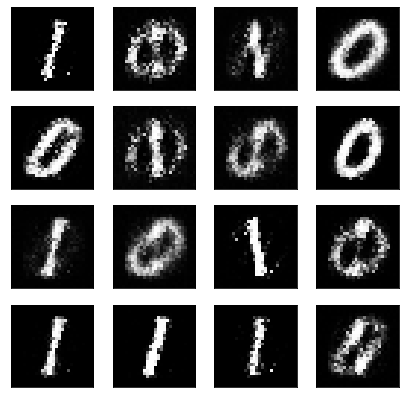

In [40]:
view_samples(generated01_trainset.data[105:1000]*255)

In [42]:
2.2443e+02

224.43

In [87]:
np.random.binomial(1, 0.7, size=None)


0